# Anomaly Detection with Isolation Forest

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# โหลดข้อมูลที่ clean แล้ว
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Stroke Prediction/healthcare-dataset-stroke-data-cleaned.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   Residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 421.9+ KB


In [5]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,42.868810,0.091891,0.049511,105.297402,28.89456,0.042584
std,22.556128,0.288901,0.216954,44.425550,7.85432,0.201937
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.10000,0.000000
75%,60.000000,0.000000,0.000000,113.495000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


In [6]:
# ตรวจสอบ na ในข้อมูล
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# เปลี่ยน data type ของ column
df['hypertension'] = df['hypertension'].astype(str)
df['heart_disease'] = df['heart_disease'].astype(str)
df['stroke'] = df['stroke'].astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   object 
 3   heart_disease      4908 non-null   object 
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   Residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 non-null   object 
dtypes: float64(3), object(8)
memory usage: 421.9+ KB


In [9]:
df_cat  = pd.get_dummies(df.select_dtypes('object') , drop_first=True)
df_cat

,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,1,0,1,1,0,1,0,0,1,1,0,0,1
1,1,0,1,1,0,1,0,0,0,0,1,0,1
2,0,0,0,1,0,1,0,0,1,0,0,1,1
3,0,1,0,1,0,0,1,0,0,0,1,0,1
4,1,0,0,1,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,0,0,0,0,0,0,0,1,0,0,0,0,0
4904,0,0,0,1,0,0,1,0,1,0,1,0,0
4905,0,0,0,1,0,0,1,0,0,0,1,0,0
4906,1,0,0,1,0,1,0,0,0,1,0,0,0


In [10]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   gender_Male                     4908 non-null   uint8
 1   hypertension_1                  4908 non-null   uint8
 2   heart_disease_1                 4908 non-null   uint8
 3   ever_married_Yes                4908 non-null   uint8
 4   work_type_Never_worked          4908 non-null   uint8
 5   work_type_Private               4908 non-null   uint8
 6   work_type_Self-employed         4908 non-null   uint8
 7   work_type_children              4908 non-null   uint8
 8   Residence_type_Urban            4908 non-null   uint8
 9   smoking_status_formerly smoked  4908 non-null   uint8
 10  smoking_status_never smoked     4908 non-null   uint8
 11  smoking_status_smokes           4908 non-null   uint8
 12  stroke_1                        4908 non-null   uint8
dtypes: 

In [11]:
df_num = df.select_dtypes('number')
df_num

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,80.0,105.92,32.5
2,49.0,171.23,34.4
3,79.0,174.12,24.0
4,81.0,186.21,29.0
...,...,...,...
4903,13.0,103.08,18.6
4904,81.0,125.20,40.0
4905,35.0,82.99,30.6
4906,51.0,166.29,25.6


In [12]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4908 non-null   float64
 1   avg_glucose_level  4908 non-null   float64
 2   bmi                4908 non-null   float64
dtypes: float64(3)
memory usage: 115.2 KB


In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
df_num_scaler = StandardScaler().fit_transform(df_num)
df_num_scaler

array([[ 1.06993757,  2.77779723,  0.98114481],
       [ 1.64633634,  0.01401584,  0.45908589],
       [ 0.27184695,  1.48426559,  0.70101563],
       ...,
       [-0.34889019, -0.50218118,  0.21715615],
       [ 0.36052369,  1.37305699, -0.41950107],
       [ 0.05015511, -0.45062901, -0.3431022 ]])

In [15]:
df_num_scaler_final = pd.DataFrame(df_num_scaler, columns=df_num.columns, index=df_num.index)
df_num_scaler_final

,age,avg_glucose_level,bmi
0,1.069938,2.777797,0.981145
1,1.646336,0.014016,0.459086
2,0.271847,1.484266,0.701016
3,1.601998,1.549325,-0.623231
4,1.690675,1.821493,0.013426
...,...,...,...
4903,-1.324334,-0.049918,-1.310821
4904,1.690675,0.448045,1.414072
4905,-0.348890,-0.502181,0.217156
4906,0.360524,1.373057,-0.419501


In [16]:
df_final = pd.concat([df_num_scaler_final, df_cat],axis=1) # axis=1 จะเป็นการต่อในแนวนอน
df_final

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,1.069938,2.777797,0.981145,1,0,1,1,0,1,0,0,1,1,0,0,1
1,1.646336,0.014016,0.459086,1,0,1,1,0,1,0,0,0,0,1,0,1
2,0.271847,1.484266,0.701016,0,0,0,1,0,1,0,0,1,0,0,1,1
3,1.601998,1.549325,-0.623231,0,1,0,1,0,0,1,0,0,0,1,0,1
4,1.690675,1.821493,0.013426,1,0,0,1,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,-1.324334,-0.049918,-1.310821,0,0,0,0,0,0,0,1,0,0,0,0,0
4904,1.690675,0.448045,1.414072,0,0,0,1,0,0,1,0,1,0,1,0,0
4905,-0.348890,-0.502181,0.217156,0,0,0,1,0,0,1,0,0,0,1,0,0
4906,0.360524,1.373057,-0.419501,1,0,0,1,0,1,0,0,0,1,0,0,0


In [17]:
y = df_final['stroke_1']
X = df_final.drop('stroke_1', axis=1)

In [18]:
y

0       1
1       1
2       1
3       1
4       1
       ..
4903    0
4904    0
4905    0
4906    0
4907    0
Name: stroke_1, Length: 4908, dtype: uint8

In [19]:
X

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,2.777797,0.981145,1,0,1,1,0,1,0,0,1,1,0,0
1,1.646336,0.014016,0.459086,1,0,1,1,0,1,0,0,0,0,1,0
2,0.271847,1.484266,0.701016,0,0,0,1,0,1,0,0,1,0,0,1
3,1.601998,1.549325,-0.623231,0,1,0,1,0,0,1,0,0,0,1,0
4,1.690675,1.821493,0.013426,1,0,0,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,-1.324334,-0.049918,-1.310821,0,0,0,0,0,0,0,1,0,0,0,0
4904,1.690675,0.448045,1.414072,0,0,0,1,0,0,1,0,1,0,1,0
4905,-0.348890,-0.502181,0.217156,0,0,0,1,0,0,1,0,0,0,1,0
4906,0.360524,1.373057,-0.419501,1,0,0,1,0,1,0,0,0,1,0,0


## Modeling

In [20]:
X

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,2.777797,0.981145,1,0,1,1,0,1,0,0,1,1,0,0
1,1.646336,0.014016,0.459086,1,0,1,1,0,1,0,0,0,0,1,0
2,0.271847,1.484266,0.701016,0,0,0,1,0,1,0,0,1,0,0,1
3,1.601998,1.549325,-0.623231,0,1,0,1,0,0,1,0,0,0,1,0
4,1.690675,1.821493,0.013426,1,0,0,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,-1.324334,-0.049918,-1.310821,0,0,0,0,0,0,0,1,0,0,0,0
4904,1.690675,0.448045,1.414072,0,0,0,1,0,0,1,0,1,0,1,0
4905,-0.348890,-0.502181,0.217156,0,0,0,1,0,0,1,0,0,0,1,0
4906,0.360524,1.373057,-0.419501,1,0,0,1,0,1,0,0,0,1,0,0


https://utsavdesai26.medium.com/unsupervised-machine-learning-with-anomaly-detection-5fae4fd2c957

In [31]:
from sklearn.ensemble import IsolationForest

# Train the model
model = IsolationForest(contamination=0.05, random_state=42) # contamination เป็นตัวกำหนดสัดส่วนของ outliers บน data set ที่จะใช้ในการหา
model.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

In [32]:
# ทำนายและระบุสถานะปกติ/ผิดปกติ
predictions = model.predict(X)

# เปลี่ยนค่า -1 เป็น 1, 1 เป็น 0 เพราะใน IsolationForest จะให้ abnormal = -1 และ normal = 1
predictions[predictions == 1] = 0 # normal
predictions[predictions == -1] = 1 # stroke

df['predictions'] = predictions

In [33]:
# เปลี่ยน data type ของ column
df['stroke'] = df['stroke'].astype(int)

In [34]:
pd.crosstab(df['predictions'], columns='Count')

col_0,Count
predictions,
0,4662
1,246


In [35]:
df.query("predictions == 1 & stroke == 1").count()

gender               39
age                  39
hypertension         39
heart_disease        39
ever_married         39
work_type            39
Residence_type       39
avg_glucose_level    39
bmi                  39
smoking_status       39
stroke               39
predictions          39
dtype: int64

In [36]:
df.query("predictions == 0 & stroke == 0").count()

gender               4492
age                  4492
hypertension         4492
heart_disease        4492
ever_married         4492
work_type            4492
Residence_type       4492
avg_glucose_level    4492
bmi                  4492
smoking_status       4492
stroke               4492
predictions          4492
dtype: int64

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# สร้าง Confusion Matrix
cm = confusion_matrix(df['stroke'], df['predictions'])

# แสดง Confusion Matrix
print("Confusion Matrix:")
print(cm)

# แสดง Classification Report
print("\nClassification Report:")
print(classification_report(df['stroke'], df['predictions']))


Confusion Matrix:
[[4492  207]
 [ 170   39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4699
           1       0.16      0.19      0.17       209

    accuracy                           0.92      4908
   macro avg       0.56      0.57      0.57      4908
weighted avg       0.93      0.92      0.93      4908



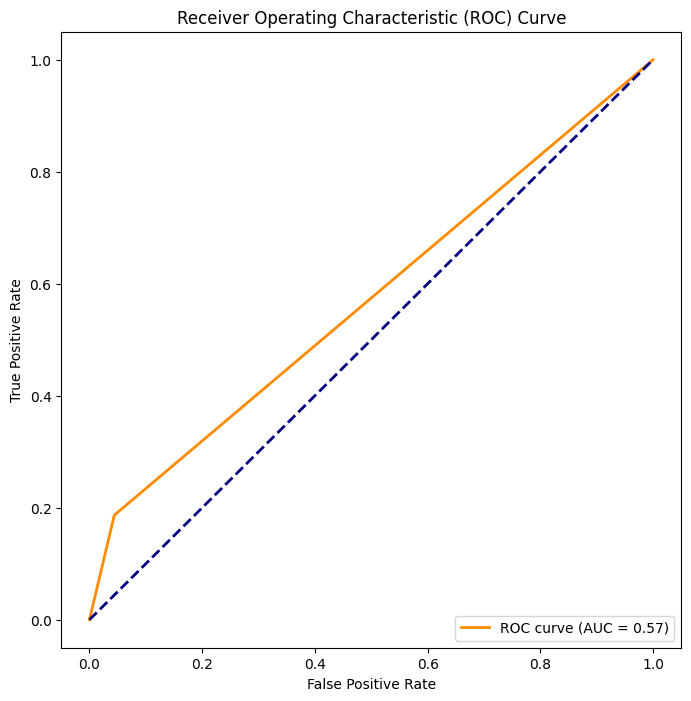

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# คำนวณ False Positive Rate และ True Positive Rate
fpr, tpr, thresholds = roc_curve(df['stroke'], df['predictions'])

# คำนวณ Area Under the ROC Curve (AUC-ROC)
auc_score = auc(fpr, tpr)

# แสดง ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




---



### ลองดูค่า contamination

In [46]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# ทดลองด้วยค่า contamination ต่าง ๆ
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2]

results_df = pd.DataFrame(columns=['Contamination', 'AUC', 'Accuracy', 'F1-score'])

for contamination_value in contamination_values:
    iso_forest = IsolationForest(contamination=contamination_value, random_state=42)
    iso_forest.fit(X)

    predictions = iso_forest.predict(X)
    predictions[predictions == 1] = 0
    predictions[predictions == -1] = 1

    auc = roc_auc_score(y, predictions)
    accuracy = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions)

    results_df = results_df.append({'Contamination': contamination_value,
                                    'AUC': auc,
                                    'Accuracy': accuracy,
                                    'F1-score': f1}, ignore_index=True)


results_df


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-46-23f4f1164c33>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Contamination': contamination_value,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-46-23f4f1164c33>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Contamination': contamination_value,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
 

,Contamination,AUC,Accuracy,F1-score
0,0.01,0.524665,0.952119,0.092664
1,0.05,0.571275,0.923187,0.171429
2,0.10,0.615171,0.884678,0.191429
3,0.15,0.651464,0.844743,0.194503
4,0.20,0.652881,0.799307,0.172964
